<a href="https://colab.research.google.com/github/drpOpZ/a4md_exam/blob/main/LZ77%20-%20Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is work is my final project submission for the course **Algorithms for Massive Data** offered by **University of Trieste** within the **Data Science and Scientific Computing** master degree programme during the **academic year 2020/2021**.  
Student name: Michele Rispoli

# Introduction
In a nutshell, a **compression algorithm** comprises an **encoding** procedure, which takes some input data and computes a more compact representation of it, and a corresponding **decoding** procedure, which reconstructs (at least partially) the original input from its compressed representation. As imaginable, they play a central role in *information theory*, since reduced file sizes generally ease data transmission and storage.

![coder/decoder](https://ars.els-cdn.com/content/image/3-s2.0-B9780750663106500040-f01-02-9780750663106.gif)  


Results from **Kolmogorov complexity theory**, which studies data compression from an abstract point of view, demonstrate that compressibility is an *undecidable problem*. In practice, this translates to the fact that no single algorithm can achieve the best compression for every possible input. We're faced with a no-free-lunch scenario, legitimating the [ample *buffet*](https://en.wikipedia.org/wiki/List_of_algorithms#Lossless_compression_algorithms) of available compression algorithms.

A broad distinction can be made between **lossless** and **lossy** compression algorithms: as the names suggest,
the former preserve all of the original information during the encoding phase, allowing for an exact reconstruction of the original data from its compressed counterpart during the decoding phase, while the latter discard part of the original signal (typically basing on use-case specific statistical analysis), so that the fidelity of the decompressed data is just sufficient to serve the intended purpose.

![lossless compression](https://ethw.org/w/images/6/6d/Compression_hierarchy.png)  
*Hierarchy of lossless compression algorithms.*

In this work we'll take a closer look at **LZ77** (a.k.a. *LZ1*), a general purpose, lossless compression algorithm that was first presented in 1977 in a paper [1] by *Abraham Ziv* and *Jacob Lempel* (hence its name).
It is regarded as a [milestone](https://ethw.org/Milestones:Lempel-Ziv_Data_Compression_Algorithm,_1977) in the history of compression algorithms, as it gave birth to an entire family of LZ-derived algorithms, some of which are still widely used at the present date.  
The key novelty introduced with this algorithm is the idea of using a fixed-size *sliding window* (or *circular buffer*) to process the data during both encoding and decoding, effectively making it an *online* algorithm.

## Content overview
FIX THIS  
After briefly introducing the **string notation** used in this work, we'll start reviewing the contents of the original LZ77 paper, presenting the **encoding and decoding procedures in detail**.  
We'll then pause the review to present a simple **python implementation** of the LZ77 encoding and decoding algorithms, following a quick demonstration to
test their correctedness and measure their performance empirically.  
Finally we'll get back to the paper, reviewing the **theoretical results** on the algorithm's performance.  
All the **referenced resources** can be found listed at the end of the notebook.

# Notation Remarks
- $\Sigma$ is a finite *alphabet* of cardinality $|\Sigma|$
- $\Sigma^*$ is the set of finite *strings* on $\Sigma$
- Srings are represented using capital letters e.g. $S,B\in \Sigma^*$
- $\varepsilon$ represents the *empty string*
- literal characters and strings will use the formatting $\texttt{a,b,0,...}$ 
- $A\cdot B$ is the *concatenation* of strings/characters/literals
- $A^n$ is the string obtained by concatenating $A$ with itself exactly $n$ times; in particular $A^n = \varepsilon$ if $n<1$

furthermore we shall use the following notation to represent a **substring**s:
$$S[i\stackrel{l}{...}j]$$
where 
- $i,j\in \{1,...,|S|\}$ are the indices of the first and last characters
- $l= \max\{j-i+1,0\}\geq 0$ is the length of the substring;

the latter definition allows us to interpret the case in which $i>j$ as $\varepsilon$; notice that it's sufficient to specify only two of $i,l,j$ to unambiguosly identify a substring: we shall exploit this redundancy and omit (at least) one of them, as is more convenient.  
We shall further simplify the notation by only specifying $i$ or $j$ (and the three dots) when referring to **suffix**es or **prefix**es of $S$ respectively.  
Furthermore, we shall use the notation $S[i]$ to address the $i$-th character of $S$ (i.e. substring of length 1).

Example:  
$$\begin{aligned} S &= \texttt{zivlempel}\\
S[4] = S[4\stackrel{1}{...}] = S[\stackrel{1}{...}4]&= \texttt{l}\\
S[\ldots4] &= \texttt{zivl}\\
S[4\ldots] &= \texttt{lempel}\\
S[2\ldots4] = S[\stackrel{3}{...}4] = S[2\stackrel{3}{...}] &= \texttt{ivl}\\
S[2\ldots1] = S[2\stackrel{0}{...}] = S[\stackrel{0}{...}1]&= \varepsilon
\end{aligned}$$

# LZ77 Algorithm
This section presents the **encoding** and **decoding** procedures that comprise LZ77 as detailed in the original paper \[1\], starting with the definition of **reproducible extension**.  

I revisited the notation in the attempt of making it clearer than the original (although, at times, more cumbersome).  

## Definition: Reproducible Extension
Given $B\in \Sigma^*$, let $B[...j]$ be a *proper prefix* of $B$; for each $i\in \{1,...,j\}$ let

$$\text{L}_j(i,B) := \max \{l\in \{0,...,|B|-j\} : B[i\stackrel{l}{...}] = B[j+1\stackrel{l}{...}]\},$$

that is, the *length of the longest substring* of $B$ starting at $i\leq j$ and matching a prefix of $B[j+1 ...]$ (note that the two may overlap), and let

$$\text{L}_j(B) := \max_{i\leq j} \text{L}_j(i,B),$$

we thus define the **reproducible extension** of $B[...j]$ into $B$ as
$$\text{RE}_j(B) := B[j+1\stackrel{\text{L}_j(B)}{...}]\ .$$

It'll be useful to keep track of the *starting position of the nearest previous occurence* of $\text{RE}_j(B)$:
$$
p_j(B) := \max \{p : \text{L}_j(p,B) =\text{L}_j(B)\}.
$$

Note that when $\text{RE}_j(B)=\varepsilon$ (that is, $\text{L}_j(B)=0$) we have $p_j(B)=j$.

For any given $B$ and $j$, $\text{RE}_j(B)$ can be uniquely identified with the pair $(p_j(B),\text{L}_j(B))$.  

### Reproducible Extension Example  
*(NOTE: $B$ is omitted for brevity)*
$$\begin{aligned} B &= \texttt{abacab}\underline{\texttt{d}}\texttt{abc}\\
\text{L}_7(1) = \text{L}_7(5) &= 2\\
\text{L}_7(2) = \text{L}_7(7) &= 0\\
\text{L}_7(3) &= 1\\
\text{L}_7 = \text{L}_7(5) &= 2\\
\text{RE}_7 &= \texttt{ab}\\
p_7 &= 5\\
\end{aligned}$$

## Encoding Procedure
The general idea of the encoding procedure is substituting repeating patterns with references to their previous occurence, given that these repetitions occur within a predefinite distance.
This is accomplished by "sliding" a buffer $B$ of fixed size over the input stream $S$, computing the reproducible extension of the leftmost part of $B$ onto the rest minus the last character and storing the (index, length, next character) triplet, over and over again untill the entire input string has been translated into a stream of triplets.

More precisely, let $B_i$ be the content of the *sliding window* at the beginning of step $i$, with $|B_i|=\ell_B=\ell_S + \ell_L \ \forall\ i$, where $\ell_S$ and $\ell_B$ are the fixed *search buffer size* and *look-ahead buffer size* respectively.  
The initial state of the buffer is

$$B_1 = \texttt{0}^{\ell_S} \cdot S[1\stackrel{\ell_L}{...}]$$

that is, initially it only cointains $\ell_S$ copies of some fixed padding character $\texttt{0}\in\Sigma$, followed by the first $\ell_L$ characters of $S$ (note: it is reasonable to assume that $S$ will have enough characters, otherwise some right padding can be applied).

The algorithm then computes for $i\geq 1$

$$\begin{aligned}
\pi_i &= p_{\ell_S}(B_i[...\ell_B-1]) - 1 &\in \{0,...,\ell_S-1\}\\
\lambda_i &= \text{L}_{\ell_S}(B_i[...\ell_B-1]) &\in \{0,...,\ell_L-1\}\\
c_i &= B_i[\ell_S+1+\lambda_i] &\in \Sigma\\
\end{aligned}$$

This triplet uniquely identifies the substring (a.k.a. *source word*)

$$S_i := B_i[\ell_S+1\stackrel{\lambda_i + 1}{...} ]=  S[i + \sum_{j<i}\lambda_j \stackrel{\lambda_i + 1}{...}],$$

hence its base-$|\Sigma|$ representation $C_i\in\Sigma^*$ effectively constitutes an encoding of this substring. We thus define the $i$-th *encoded word* of the input $S$ as

$$C_i := \langle\pi_i\rangle_{|\Sigma|} \cdot \langle\lambda_i\rangle_{|\Sigma|} \cdot c_i.$$

$\forall\ i,\ C_i$ can always be stored using exactly

$$\ell_C := |C_i| = \lceil\log_{|\Sigma|}\ell_S\rceil + \lceil\log_{|\Sigma|}\ell_L\rceil + 1 \geq 3$$

characters of $\Sigma$.

The only thing left to do is updating the buffer by sliding it forward, that is, removing $\lambda_i+1$ characters on the left and feeding in the next  characters of $S$ (as before, eventually adding some padding $\texttt{0}$s on the right if necessary):

$$B_{i+1} = B_i[\lambda_i+2\ldots] \cdot S[\ell_L + \sum_{j\leq i}(\lambda_j+1) \stackrel{\lambda_i + 1}{...}]$$

![encoding overview](https://github.com/drpOpZ/a4md_exam/blob/main/images/encode.svg?raw=true)

Notice that it may happen that $\lambda_i + 1 < \ell_C$, that is, that a codeword takes more characters than the corresponding sourceword (e.g. most surely when $i=1$ because the search buffer is full of padding characters); when $S$ is highly entropic or $\ell_S,\ell_L$ are chosen poorly this can happen so frequently that the encoded sequence turns up to be *inflated* rather than compressed in the process. Some possible tweaks to mitigate this problem include performing a preliminary analysis to find optimal values of $\ell_S,\ell_L$ and preceding codewords with a character or sequence that doesn't appear in $S$, so that the problematic segments can be left untouched.

That said, let's work out an example by hand to show that, despite the tricky notation, this encoding procedure is pretty intuitive.

### Encoding Example

$$\begin{aligned}
\Sigma &= \{\texttt{0},\texttt{1},\texttt{2}\} &|\Sigma| = 3\\
S &= \texttt{1010112121210102}  &|S| = 16\\
\ell_B &= 18,\ \ell_S = 9,\ \ell_L=9\\
\ell_C &= \lceil\log_39\rceil + \lceil\log_39\rceil + 1 = 5
\end{aligned}$$

$$\begin{matrix}
i & B_i&\pi_i &\lambda_i &c_i &C_i\\
1 & \texttt{00000000}\underline{\texttt{0}}\,\texttt{101011212}
& 8 & 0 & \texttt{1} & \texttt{22 00 1}\\
2 & \texttt{00000000}\underline{\texttt{1}}\,\texttt{010112121}
& 7 & 4 & \texttt{1} & \texttt{21 11 1}\\
3 & \texttt{00010101}\underline{\texttt{1}}\,\texttt{212121010}
& 8 & 0 & \texttt{2} & \texttt{22 00 2}\\
4 & \texttt{00101011}\underline{\texttt{2}}\,\texttt{121210102}
& 7 & 5 & \texttt{0} & \texttt{21 12 0}\\
5 & \texttt{11212121}\underline{\texttt{0}}\,\texttt{102......}
& 7 & 2 & \texttt{2} & \texttt{21 02 2}\\
\end{matrix}$$

$$ C = \texttt{2200121111220022112021022},\ |C|=25$$

Yes, this example also demonstrates the "inflating problem". We'll get to see actual compression in a couple paragraphs, promise! 

## Decoding Procedure
The decoding procedure is very straightforward and less resource demanding than its counterpart: while encoding requires matching strings to spot the longest repeated word, in this case we simply need to copy characters from a *decoding buffer* as instructed by the current block $C_i$ in order to reconstruct the corresponding source word $S_i$.  

The input file is read online, one block at a time, and we only need to keep the last $\ell_S$ decoded characters in our decoding buffer. The buffer is initially filled with the same padding character used during encoding.  
The sizes of the block's components must also be known by the decoding algorithm (e.g. passing $\ell_S, \ell_L$ and $|\Sigma|$ in input). 

We'll decode the result of the previous example to illustrate the process.

### Decoding Example

$$\begin{aligned}
\Sigma &= \{\texttt{0},\texttt{1},\texttt{2}\} &|\Sigma| = 3\\
C &= \texttt{2200121111220022112021022} &|C|=25\\
\ell_S &= 8,\ \ell_C = 2 + 2 + 1\\
\end{aligned}$$


$$\begin{matrix}
i & B_i &C_i &\pi_i &\lambda_i &c_i  &S_i\\
1 & \texttt{000000000} & \texttt{22 00 1} & 8 & 0 & \texttt{1} & \texttt{1}\\
2 & \texttt{000000001} & \texttt{21 11 1} & 7 & 4 & \texttt{1} & \texttt{01011}\\
3 & \texttt{000101011} & \texttt{22 00 2} & 8 & 0 & \texttt{2} & \texttt{2}\\
4 & \texttt{001010112} & \texttt{21 12 0} & 7 & 5 & \texttt{0} & \texttt{121210}\\
5 & \texttt{112121210} & \texttt{21 02 2} & 7 & 2 & \texttt{2} & \texttt{102}\\
\end{matrix}$$

$$S = \texttt{1010112121210102},\ |S| = 16$$

# Pyhon Implementation
We'll now take a look at a basic python implementation of the encoding and decoding procedures of the LZ77 algorithm.  
The original paper limits to a theoretical presentation of the algorithm, hence the following design choices were taken to keep things reasonably simple:
- **naive string matching** is used to compute $\lambda_i$ during encoding;
- **lookup and search buffer sizes are prefixed** and given in input to both encoding and decoding procedures (more precisely, to the subroutines that perform the single steps); a more effective approach would require letting the encoder figure out the optimal values of $\ell_L$ and $\ell_S$ for each input file and write them in the header of the compressed file; the decoder would then read these values and adjust itself accordingly;
- **lookup and search buffer sizes are powers of 256**, so that they can be represented using an integer number of bytes (i.e. characters of our alphabet); this doesn't give us much play room to tune the parameters, but spares us the additional complexity of working with single bits; their value shouldn't be set above 2 to keep execution time reasonable;
- **no countermeasures to the inflating problem** are included; again, simplicity is our main focus. 

Without further ado, let's dig right into the code!

In [1]:
# LZ77 ENCODING PROCEDURE

# import struct #for packing/unpacking encoded blocks
import os

# Encoding step: processes buffer, computes RE by repeated naive string matching
def compute_block_parameters(buff:bytearray,search_size:int):

  # assumes len(buff)>search_size, assert in main routine 
  lookahead_size = len(buff) - search_size

  # naive string matching 
  longest_match = 0
  pos = 0 
  for iii in range(search_size):
    matched_bytes = 0
    for jjj in range(lookahead_size-1):
      if (buff[iii+jjj]!=buff[search_size + jjj]):
        break
      matched_bytes+=1
    if (matched_bytes>=longest_match):
      pos = iii
      longest_match = matched_bytes

  next_char = buff[search_size+longest_match].to_bytes(1,'big')

  return pos, longest_match, next_char

# Encodes the input file into the output file and prints some encoding statistics
def lz77_encode(input_filename,output_filename, search_bytes=1, lookahead_bytes=1,verbose=True):
  assert(input_filename != output_filename)
  assert(search_bytes>0 and lookahead_bytes>0)

  search_size = 256**search_bytes
  lookahead_size = 256**lookahead_bytes

  input_size = os.path.getsize(input_filename)

  buffer = bytearray(search_size)
  with open(input_filename,'rb') as f_in, open(output_filename,'wb') as f_out:

    buffer.extend(f_in.read(lookahead_size))

    bytes_encoded = 0
    blocks = 0
    while bytes_encoded < input_size:
      # compute and write next block
      pos, word_length, next_char = compute_block_parameters(buffer,search_size)

      f_out.write(pos.to_bytes(search_bytes,'big'))
      f_out.write(word_length.to_bytes(lookahead_bytes,'big'))
      f_out.write(next_char)

      # update buffer 
      shift = word_length+1
      buffer = buffer[shift:] + f_in.read(shift)
      bytes_encoded += shift

      # block statistics
      blocks += 1

  # screen output    
  if (verbose):
    output_size = os.path.getsize(output_filename)
    compression_ratio = output_size / input_size
    print("'" + input_filename + "' encoded into '" + output_filename +"'\n",
          "\tInput Size:\t\t", input_size, " B"," (= encoded? ",bytes_encoded == input_size,")\n",
          "\tOutput Size:\t\t", output_size, " B\n",
          "\tCompression Ratio:\t", compression_ratio, "\n",
          "\tOutput Blocks:\t\t", blocks, "\n",
          "\tAvg Bytes per Block:\t", input_size/blocks)

In [2]:
# LZ77 DECODING PROCEDURE

# Decoding step: reconstruct the source word from buffer and block parameters
def decode_block(buff:bytearray,pos,length,nextch:bytes):
  
  #it is assumed that 0 <= pos < len(buff)
  if length == 0:
    return nextch

  elif pos + length <= len(buff):
    return buff[pos : pos+length] + nextch
  
  else:
    # overlap case
    return buff[pos:]*(length//(len(buff)-pos))+\
           buff[pos:pos+(length%(len(buff)-pos))] +\
           nextch

# decodes input_filename into output_filename with given parameters
def lz77_decode(input_filename,output_filename, search_bytes=1, lookahead_bytes=1):
  assert(search_bytes>0 and lookahead_bytes>0)
  
  buffer = bytearray(256**search_bytes)

  with open(input_filename, "rb") as f_in, open(output_filename, "wb") as f_out:
    cw_bytes = search_bytes + lookahead_bytes + 1
    codeword = f_in.read(cw_bytes)
    while ( codeword != b'' ):
      
      pos = int.from_bytes(codeword[:search_bytes],'big')
      length = int.from_bytes(codeword[search_bytes:-1],'big')
      nextch = codeword[-1:]

      decoded_word = decode_block(buffer,pos,length,nextch)

      f_out.write(decoded_word)

      buffer = buffer[length+1:] + decoded_word
      codeword = f_in.read(cw_bytes)

## Correctedness test
Before inquiring on the complexity and performance of the algorithm, let's make some test to ensure that it works as expected.

First let's test the subroutines:

In [3]:
# UNIT TEST: COMPUTE_BLOCK 
# Checking that the encoding sub-routine is working properly
for buff, search_size, expected_out in [[b'020177777',4,(3,0,b'7')],  # no match --> (3,0,b'7')
                                        [b'020107777',4,(2,1,b'7')],  # 1 match  --> (2,1,b'7')
                                        [b'001010101',4,(2,4,b'1')]]: # 4 match w/ overlap --> (2,4,b'1') 
  actual_out = compute_block_parameters(buff, search_size)
  print("compute_block_parameters(",buff,",", search_size,")=", actual_out, '==', expected_out, '? ',actual_out == expected_out)

compute_block_parameters( b'020177777' , 4 )= (3, 0, b'7') == (3, 0, b'7') ?  True
compute_block_parameters( b'020107777' , 4 )= (2, 1, b'7') == (2, 1, b'7') ?  True
compute_block_parameters( b'001010101' , 4 )= (2, 4, b'1') == (2, 4, b'1') ?  True


In [4]:
# UNIT TEST: DECODE_BLOCK
# Checking that decoding sub-routine is working properly
for buff, pi_i, lambda_i, next_c, expected_out in [[b'1234',3,0,b'7', b'7'],        # length 0    b'7'
                                                   [b'1234',2,2,b'7', b'347'],      # no overlap  b'347'
                                                   [b'1234',2,6,b'7', b'3434347']]: # overlap     b'3434347'
  actual_out = decode_block(buff, pi_i, lambda_i, next_c)
  print("decode_block(",buff,",", pi_i,",", lambda_i,",", next_c, ")= ",actual_out, '==', expected_out, '? ',actual_out == expected_out)

decode_block( b'1234' , 3 , 0 , b'7' )=  b'7' == b'7' ?  True
decode_block( b'1234' , 2 , 2 , b'7' )=  b'347' == b'347' ?  True
decode_block( b'1234' , 2 , 6 , b'7' )=  b'3434347' == b'3434347' ?  True


The tests look good, let's see how the main routines deal with a real task.  
We'll download the HTML page of the [wikipedia entry for LZ77 and LZ78](https://en.wikipedia.org/wiki/LZ77_and_LZ78), encode and then decode it.  
We're interested in verifying

- that the encoded->decoded file matches the original
- that the encoded file is smaller than the original

We'll use a simple routine that compares the files byte-per-byte to assess the first, while the verbose output of `lz77_encode` shall take care of the second

In [ ]:
# CORRECTEDNESS TEST

# routine for checking that two files are equal
def chk_files(fname1, fname2):
  same = True
  with open(fname1, "rb") as f1, open(fname2, "rb") as f2:
    while (same):
      c1 = f1.read(1)
      c2 = f2.read(1)
      if (c1 == b'' and c2 == b''):
          break
      same = c1 == c2

  return same

In [ ]:
!curl https://en.wikipedia.org/wiki/LZ77_and_LZ78 --output lzwiki.html

# encode the page
lz77_encode('lzwiki.html', 'lzwiki.lz',1,1)

# decode the compressed file and check if it matches the original
lz77_decode('lzwiki.lz', 'lzwiki_dec.html',1,1)
print("\nDid 'lzwiki.lz' survive the encoding+decoding procedure?",chk_files('lzwiki.html','lzwiki_dec.html'))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88516  100 88516    0     0   502k      0 --:--:-- --:--:-- --:--:--  502k
'lzwiki.html' encoded into 'lzwiki.lz'
 	Input Size:		 88516  B  (= encoded?  True )
 	Output Size:		 65757  B
 	Compression Ratio:	 0.7428826426860681 
 	Output Blocks:		 21919 
 	Avg Bytes per Block:	 4.038322916191432

Did 'lzwiki.lz' survive the encoding+decoding procedure? True


The test output shows us that we succesfully managed to reduce the original file size and that the decompressed file matches the input.

# Time Complexity

We'll now attempt to work out the time complexity of the encoding and decoding procedures.

In the following $N=|S|$ while $N_c$ is the number of encoded words, so that

$$N = \sum_{i=1}^{N_c} (\lambda_i+1)$$

## Encoding

The computation of a the $i$-th codeword takes exactly $\ell_S$ steps (outer `for` in `compute_block_parameters`), each performing $O(\lambda_i+1)$ operations (inner `for` and max update):

$$T_{es}(i) = O(\ell_S (\lambda_i+1)),\qquad i=1,\,\ldots\,,N_c$$

The main routine takes an initial $\Theta(\ell_B)$ to initialize the buffer, then at each of the $N_c$ steps of the `while` loop it takes 
- $T_{es}(i)$ ops to compute $C_i$
- $\Theta(\ell_C)$ ops to write the codeword onto the output file and
- $\Theta(\lambda_i+1)$ ops to update the buffer

that is

$$\begin{aligned}
T_e&= \Theta(\ell_B) + \sum_{i=1}^{N_c} \left[T_{es}(i) + \Theta(\ell_C) + \Theta(\lambda_i+1)\right]\\
&=\Theta(\ell_B) + \Theta(N_c\ell_C) + \sum_{i=1}^{N_c} \left[O(\ell_S(\lambda_i+1)) + \Theta(\lambda_i+1)\right]\\
&= \Theta(\ell_B) + \Theta(N_c\ell_C) + \Theta(N) + O(\ell_SN)
\end{aligned}$$

It's easy to see that this last sum tolls up to some $O(N)$ ops, though keeping the terms apart allows some interesting observation:
1. The first term shows that larger values of $\ell_S$ and $\ell_L$ shall be accountable for a constant increase in time-to-solution
2. The second term depends linearly on the output size, therefore strings that compress less will take more time to encode
3. The last term, which dominates the sum, derives directly from $T_{es}$ and hides a dirty little secret which eludes our formal analysis (but won't escape actual measurement)

## Decoding

In this case no string matching must be performed, hence we can expect the decoding process to be quicker.  
Decoding a single codeword takes a constant $\Theta(\ell_C)$ ops to read the codeword, plus another $\Theta(\lambda_i +1)$ to "extract" the sourceword from the buffer:

$$T_{ds}(i) = \Theta(\ell_C) + \Theta(\lambda_i+1).$$

The entire decoding procedure takes $\Theta(\ell_S)$ ops to initialize the buffer, then runs exactly $N_c$ steps:

$$\begin{aligned}
T_d &= \Theta(\ell_S) + \sum_{i=1}^{N_c}T_{ds}(i) \\
&= \Theta(\ell_S) \sum_{i=1}^{N_c} \left[\Theta(\ell_C) + \Theta(\lambda_i +1)\right] \\
&= \Theta(\ell_S) + \Theta(N_c\ell_C) + \Theta(N)\\
\end{aligned}$$

This sum is very similar to the previous, though it lacks *the hideous term*: it sure tolls up to some $\Theta(N)$, since $N_c\leq N$ and $\ell_C$ is fixed, but observation 2 also applies to this case.

# Performance
Giving a formal description of the performance of a compression algorithm is no easy task, especially for a general purpose algorithm as LZ77; more than half of the original LZ77 paper is dedicated to a rather intricate demonstration of the fact that the compression efficency of the proposed encoding algorithm is, in practice, "comparable to that of an optimal variable-to-block \[encoder\] designed to match a given source".  
Rather than trying to delve into the gritty details of this demonstration, we will work out the theoretical bounds of the **compression ratio** $\rho$ achievable with the LZ77 encoding procedure, where

$$\rho := \frac{\text{encoded size}}{\text{input size}} = \frac{N_C \ell_C}{N}.$$

Let's start by observing that,

$$N_c \approx \frac{N}{\bar\lambda+1} \implies \rho\approx\frac{\ell_C}{\bar\lambda+1}$$

where $\bar\lambda$ represents the average number of matched characters during the encoding process, which depends on $\ell_S,\ell_L$ and on the intrinsic complexity of $S$.  

We can easily see that

$$1\leq\bar\lambda+1\leq\ell_L$$

therefore we have

$$\frac{\ell_C}{\ell_L}\leq\rho\leq\ell_C.$$

It's easy to imagine the simplest strings that would produce these results, that is
- lower limit: any string cointaining solely padding characters of length that is a multiple of $\ell_L$
- upper limit: any string cointaining all distinct characters, excluding the padding character, shorter than $\ell_S$ and $|\Sigma|$

# Empirical estimates of complexity and performance
To conclude, we will attempt to confirm the validity of our time-complexity and performance estimates empirically:  
we will measure encoding time, decoding time and compression rate for strings generated by picking characters uniformly at random within a finite pool.  
We will attempt to keep $\bar\lambda$ constant regardless of the `length` of the generated strings by fixing the size of the pool (=`variety`).  

In [24]:
import random
import time
import numpy as np

# routine that generates a random string and writes it onto a file
def generateRandomBytesFile(length,variety,fname):
  values = [(x%256).to_bytes(1,'big') for x in range(1,1+variety)]
  with open(fname,'wb') as f:
    for b in random.choices(values, k=length):
      f.write(b)

# routine that computes the stat for a single iteration
def computeStats(length,variety,fname_root):
  fname_in = '{}_in'.format(fname_root)
  fname_out = '{}_out'.format(fname_root)
  fname_dec = '{}_dec'.format(fname_root)
  s = generateRandomBytesFile(length,variety,fname_in)
  
  # collect encoding/decoding statistics
  t_start = time.time()
  lz77_encode(fname_in,fname_out,1,1,verbose=False)
  t_end = time.time()
  enc_time = t_end-t_start

  t_start = time.time()
  lz77_decode(fname_out,fname_dec,1,1)
  t_end = time.time()
  dec_time = t_end-t_start

  out_size = os.path.getsize(fname_out)

  return enc_time, dec_time, out_size  

In [ ]:
# Collect data
from joblib import Parallel, delayed

repetitions = 10
str_varieties = [2**e for e in range(9)] #1 to 256
str_lengths = [2**e for e in range(10,17)] #1024 to 65536

scores = np.ndarray(shape=(len(str_varieties),len(str_lengths),3))

for vidx,vvv in enumerate(str_varieties):
  for lidx,lll in enumerate(str_lengths):
    
    # compute stats in parallel
    vl_scores = Parallel(n_jobs=repetitions)(delayed(computeStats)(lll,vvv,rrr) for rrr in range(repetitions))
        
    # compute averages and store results
    scores[vidx,lidx,:] = np.mean(np.stack(vl_scores),axis=0)
  print(vvv,end=' ')

In [38]:
# Print scores

def formatScores(enc_dec_out):
  return '{:>7.4f} {:>5.4f} {:>8.1f}'.format(enc_dec_out[0],enc_dec_out[1],enc_dec_out[2])

header = 'Length  ' + '|'.join(['{:^23}'.format(vvv) for vvv in str_varieties])
print(header)
for lidx,lll in enumerate(str_lengths):
  lscores = '|'.join([formatScores(scores[vidx,lidx]) for vidx in range(scores.shape[0])])
  print('{:>6}: {}'.format(lll,lscores))

Length             1           |           2           |           4           |           8           |          16           |          32           |          64           |          128          |          256          
  1024:  0.1904 0.0002     15.0| 0.0887 0.0010    354.0| 0.1018 0.0012    659.4| 0.1536 0.0020    939.3| 0.1992 0.0031   1194.3| 0.2891 0.0022   1426.2| 0.2939 0.0030   1570.5| 0.3925 0.0036   1727.1| 0.3990 0.0057   1988.4
  2048:  0.3430 0.0007     27.0| 0.1240 0.0017    681.6| 0.2994 0.0034   1287.6| 0.2728 0.0026   1825.2| 0.4136 0.0061   2331.0| 0.4689 0.0058   2822.4| 0.5104 0.0063   3080.7| 0.6147 0.0076   3356.7| 0.5875 0.0044   3882.3
  4096:  0.6887 0.0005     51.0| 0.3011 0.0023   1341.3| 0.4499 0.0093   2535.9| 0.6672 0.0077   3610.5| 0.8060 0.0098   4603.8| 0.9241 0.0110   5559.6| 0.9429 0.0124   6085.8| 1.0417 0.0120   6613.8| 1.2466 0.0163   7609.8
  8192:  1.3885 0.0020     99.0| 0.5461 0.0060   2647.2| 0.8495 0.0111   5034.6| 1.1804 0.0172   7176.3|

comment?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


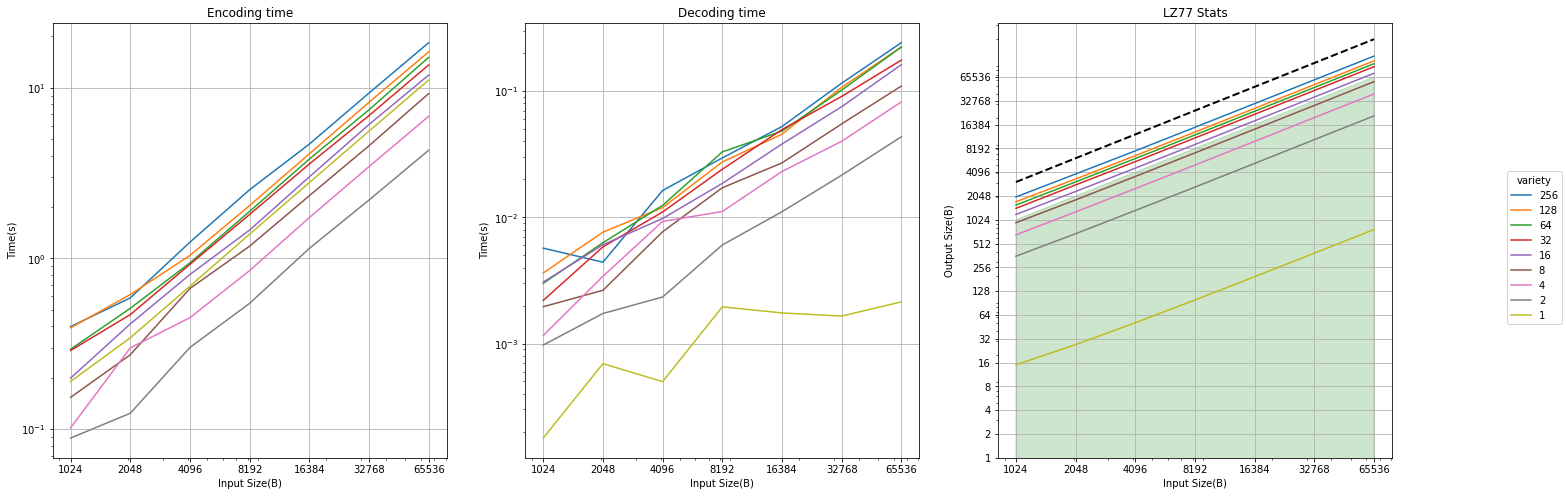

In [61]:
# Plot timing results
import matplotlib
import matplotlib.pyplot as plt

legend_handles = []

fig,axes = plt.subplots(ncols=3,figsize=(24,8))
# log-log size vs enc
for title, data_index in [["Encoding time",0],["Decoding time",1],["Output size",2]]:
  
  axes[data_index].set_title(title)
  axes[data_index].set_yscale('log')
  axes[data_index].set_xscale('log')
  axes[data_index].grid()

  for vidx in reversed(range(scores.shape[0])):
    h = axes[data_index].plot(str_lengths,scores[vidx,:,data_index])
    if data_index==0:
      legend_handles.append(h)

  # in_size reference for out_size plot
  if data_index == 2:
    axes[data_index].fill_between(str_lengths,[0 for x in str_lengths],str_lengths,color='green',alpha=.2)
    
    axes[data_index].plot(str_lengths,[3*l for l in str_lengths],ls="--",color='black',lw=2)
    
    axes[data_index].set_ylabel("Output Size(B)")
    axes[data_index].set_yticks([2**e for e in range(17)])
    axes[data_index].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

  else:
    axes[data_index].set_ylabel("Time(s)")

  axes[data_index].set_xlabel("Input Size(B)")
  axes[data_index].set_xticks(str_lengths)
  axes[data_index].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.legend(legend_handles,labels = list(reversed(str_varieties)),title='variety', loc="right")
plt.title("LZ77 Stats")
plt.show()

comment the graphs
homogeneous lambda translates to linear relation between in and outsize
encoding of var 1 shows the dirty secret

# References

\[1\] Jacob Ziv, Abrham Lempel - *A Universal Algorithm For Sequential Data Compression* - 1977  
https://www.sciencedirect.com/topics/computer-science/compression-algorithm  
https://ethw.org/History_of_Lossless_Data_Compression_Algorithms  
https://www.devdungeon.com/content/working-binary-data-python